###### Version 2 Log -> 

1) Mixed Precision Added <br>
2) Custom Model Training

In [1]:
# Necessary imports 
import math, re, os
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt 
from kaggle_datasets import KaggleDatasets 
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version: -> ", tf.__version__)


Tensorflow version: ->  2.4.1


In [2]:
AUTO = tf.data.experimental.AUTOTUNE

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()
    

print("Number of Accelerators : ", strategy.num_replicas_in_sync)

Number of Accelerators :  8


In [4]:
from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')
print(GCS_DS_PATH)

gs://kds-a5f3e552ca1eca1651815443969650adf7d40a60f75bf16a583d954d


Configuration

In [5]:
IMAGE_SIZE = [331, 331]
EPOCHS = 13 
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [6]:
# LR Scheduling

# Learning rate schedule
LR_START = 0.00001
LR_MAX = 0.00004 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .7

In [7]:
GCS_PATH_SELECT = {
    192 : GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224 : GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331 : GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512 : GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

In [8]:
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

In [9]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

In [10]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

Learning rate schedule: 1e-05 to 0.00032 to 2.25e-05


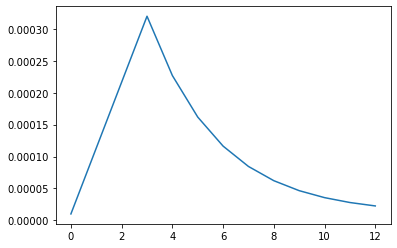

In [11]:
@tf.function
def lrfn(epoch):
    if float(epoch) < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * float(epoch) + LR_START
    elif float(epoch) < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(float(epoch) - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

#### Datasets

In [12]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_labeled_tfrecord(example):
    
    LABELED_TFREC_FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string),
        "class" : tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    
    return image, label


def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string),
        "id" : tf.io.FixedLenFeature([], tf.string)
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum


def load_dataset(filenames, labeled = True, ordered = False):
    ignore_order = tf.data.Options()
    
    if not ordered:
        ignore_order.experimental_deterministic = False
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO)
    
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    
    
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    
    
    return dataset



def get_validation_dataset(ordered = False, repeated = False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled = True, ordered = ordered)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    
    return dataset


def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = False, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    
    return dataset


def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


def int_div_round_up(a, b):
    return (a + b - 1) // b


NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
#VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE)
VALIDATION_STEPS = int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE)

#TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)
TEST_STEPS = int_div_round_up(NUM_TEST_IMAGES, BATCH_SIZE)

print("Dataset : {} training images, {} validation images, {} unlabeled test images".format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset : 12753 training images, 3712 validation images, 7382 unlabeled test images


#### Model Training

In [13]:
with strategy.scope():
    pretrained_model = tf.keras.applications.NASNetLarge(weights = 'imagenet', include_top = False)
    
    
    
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.nasnet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        # models in tf.keras.applications with include_top=False output a 3D feature map which must be converted to 2D
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'], steps_per_execution = 16)
    
model.summary()

343613440/343610240 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 331, 331, 3)       0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               419432    
Total params: 85,336,250
Trainable params: 85,139,582
Non-trainable params: 196,668
_________________________________________________________________


### Model Training

In [14]:
history = model.fit(get_training_dataset(), steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, validation_data = get_validation_dataset(), validation_steps = VALIDATION_STEPS, callbacks = [lr_callback])

Epoch 1/13

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(1e-05, shape=(), dtype=float32).
99/99 [==============================] - 482s 5s/step - loss: 4.3805 - sparse_categorical_accuracy: 0.1119 - val_loss: 3.7531 - val_sparse_categorical_accuracy: 0.2594
Epoch 2/13

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.000113333335, shape=(), dtype=float32).
99/99 [==============================] - 42s 428ms/step - loss: 1.7567 - sparse_categorical_accuracy: 0.6096 - val_loss: 1.3810 - val_sparse_categorical_accuracy: 0.6695
Epoch 3/13

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.00021666667, shape=(), dtype=float32).
99/99 [==============================] - 42s 428ms/step - loss: 0.3372 - sparse_categorical_accuracy: 0.9116 - val_loss: 0.8771 - val_sparse_categorical_accuracy: 0.7885
Epoch 4/13

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.00032, shape=(), dtype=float32).
99/99 [==

#### Model Custom Training Loop (Coming soon)

In [15]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    
    pretrained_model.trainable = True
    
    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape = [*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
        
    ])
    
    model.summary()
    
    
    class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __call__(self, step):
            return lrfn(epoch = step // STEPS_PER_EPOCH)
        
    optimizer = tf.keras.optimizers.Adam(learning_rate = LRSchedule())
    
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    train_loss = tf.keras.metrics.Sum()
    valid_loss = tf.keras.metrics.Sum()
    
    loss_fn = lambda a,b : tf.nn.compute_average_loss(tf.keras.losses.sparse_categorical_crossentropy(a,b), global_batch_size = BATCH_SIZE)
    

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 331, 331, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 11, 11, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


In [16]:
@tf.function 
def train_step(images, labels):
    with tf.GradientTape() as tape:
        probabilities = model(images, training = True)
        loss = loss_fn(labels, probabilities)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_accuracy.update_state(labels, probabilities)
    train_loss.update_state(loss)
    

@tf.function
def valid_step(images, labels):
    probabilities = model(images, training = False)
    loss = loss_fn(labels, probabilities)
    
    # update metrics
    valid_accuracy.update_state(labels, probabilities)
    valid_loss.update_state(loss)
    
    


#### Training Loop

In [17]:
import time

In [18]:
start_time = epoch_start_time = time.time()

In [19]:
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset())

valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset())

print("Steps per epoch: ", STEPS_PER_EPOCH)


Steps per epoch:  99


In [20]:
from collections import namedtuple
History = namedtuple('History', 'history')


In [21]:
history = History(history = {"loss" : [], "val_loss" : [], "sparse_categorical_accuracy" : [], "val_sparse_categorical_accuracy" : []})


epoch = 0

for step, (images, labels) in enumerate(train_dist_ds):
    strategy.run(train_step, args = (images, labels))
    print('=', end = '', flush = True)
    
    if ((step + 1) // STEPS_PER_EPOCH) > epoch:
        print('|', end = '', flush = True)
        
        for image, labels in valid_dist_ds:
            strategy.run(valid_step, args = (image, labels))
            print("=", end = '', flush = True)
            
        # metrics
        history.history['sparse_categorical_accuracy'].append(train_accuracy.result().numpy())
        history.history['val_sparse_categorical_accuracy'].append(valid_accuracy.result().numpy())
        
        epoch_time = time.time() - epoch_start_time
        print("\nEPOCH {:d}/{:d}".format(epoch + 1, EPOCHS))
        print("time : {:0.1f}s".format(epoch + 1, EPOCHS))
        print("loss : {:0.4f}".format(history.history['loss'][-1]))
        print("accuracy : {:0.4f}".format(history.history['sparse_categorical_accuracy'][-1]))
        print("val_loss : {:0.4f}".format(history.history['val_loss'][-1]))
        print("val_acc : {:0.4f}".format(history.history["val_sparse_categorical_accuracy"][-1]))
        print("lr : {:0.4g}".format(lrfn(epoch)), flush = True)
        
    epoch = (step + 1) // STEPS_PER_EPOCH
    
    epoch_start_time = time.time()
    train_accuracy.reset_states()
    valid_accuracy.reset_states()
    
    valid_loss.reset_states()
    train_loss.reset_states()
    
    if epoch >= EPOCHS:
        break
        
        
simple_ctl_training_time = time.time() - start_time 
print("Training Time -> ", simple_ctl_training_time)
    

===================================================================================================|=============================
EPOCH 1/13
time : 1.0s


IndexError: list index out of range

## Optimized Model Training

In [22]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model.summary()
    
    # Instiate optimizer with learning rate schedule
    class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __call__(self, step):
            return lrfn(epoch=step//STEPS_PER_EPOCH)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule())
        
    # this also works but is not very readable
    #optimizer = tf.keras.optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//STEPS_PER_EPOCH))
    
    # Instantiate metrics
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss = tf.keras.metrics.Sum()
    valid_loss = tf.keras.metrics.Sum()
    
    # Loss
    # The recommendation from the Tensorflow custom training loop  documentation is:
    # loss_fn = lambda a,b: tf.nn.compute_average_loss(tf.keras.losses.sparse_categorical_crossentropy(a,b), global_batch_size=BATCH_SIZE)
    # https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function
    # This works too and shifts all the averaging to the training loop which is easier:
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 331, 331, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 11, 11, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


In [23]:
STEPS_PER_TPU_CALL = 99
VALIDATION_STEPS_PER_TPU_CALL = 29

@tf.function
def train_step(data_iter):
    def train_step_fn(images, labels):
        with tf.GradientTape() as tape:
            probabilities = model(images, training=True)
            loss = loss_fn(labels, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        #update metrics
        train_accuracy.update_state(labels, probabilities)
        train_loss.update_state(loss)
        
    # this loop runs on the TPU
    for _ in tf.range(STEPS_PER_TPU_CALL):
        strategy.run(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(images, labels):
        probabilities = model(images, training=False)
        loss = loss_fn(labels, probabilities)
        
        # update metrics
        valid_accuracy.update_state(labels, probabilities)
        valid_loss.update_state(loss)
        
    # this loop runs on the TPU
    for _ in tf.range(VALIDATION_STEPS_PER_TPU_CALL):
        strategy.run(valid_step_fn, next(data_iter))

In [24]:
import time
from collections import namedtuple

In [25]:
start_time = epoch_start_time = time.time()

# distribute the datset according to the strategy
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset())
# Hitting End Of Dataset exceptions is a problem in this setup. Using a repeated validation set instead.
# This will introduce a slight inaccuracy because the validation dataset now has some repeated elements.
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(repeated=True))

print("Training steps per epoch:", STEPS_PER_EPOCH, "in increments of", STEPS_PER_TPU_CALL)
print("Validation images:", NUM_VALIDATION_IMAGES,
      "Batch size:", BATCH_SIZE,
      "Validation steps:", NUM_VALIDATION_IMAGES//BATCH_SIZE, "in increments of", VALIDATION_STEPS_PER_TPU_CALL)
print("Repeated validation images:", int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE*VALIDATION_STEPS_PER_TPU_CALL)*VALIDATION_STEPS_PER_TPU_CALL*BATCH_SIZE-NUM_VALIDATION_IMAGES)
History = namedtuple('History', 'history')
history = History(history={'loss': [], 'val_loss': [], 'sparse_categorical_accuracy': [], 'val_sparse_categorical_accuracy': []})

epoch = 0
train_data_iter = iter(train_dist_ds) # the training data iterator is repeated and it is not reset
                                      # for each validation run (same as model.fit)
valid_data_iter = iter(valid_dist_ds) # the validation data iterator is repeated and it is not reset
                                      # for each validation run (different from model.fit whre the
                                      # recommendation is to use a non-repeating validation dataset)

step = 0
epoch_steps = 0
while True:
    
    # run training step
    train_step(train_data_iter)
    epoch_steps += STEPS_PER_TPU_CALL
    step += STEPS_PER_TPU_CALL
    print('=', end='', flush=True)

    # validation run at the end of each epoch
    if (step // STEPS_PER_EPOCH) > epoch:
        print('|', end='', flush=True)
        
        # validation run
        valid_epoch_steps = 0
        for _ in range(int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE*VALIDATION_STEPS_PER_TPU_CALL)):
            valid_step(valid_data_iter)
            valid_epoch_steps += VALIDATION_STEPS_PER_TPU_CALL
            print('=', end='', flush=True)

        # compute metrics
        history.history['sparse_categorical_accuracy'].append(train_accuracy.result().numpy())
        history.history['val_sparse_categorical_accuracy'].append(valid_accuracy.result().numpy())
        history.history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE*epoch_steps))
        history.history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE*valid_epoch_steps))
        
        # report metrics
        epoch_time = time.time() - epoch_start_time
        print('\nEPOCH {:d}/{:d}'.format(epoch+1, EPOCHS))
        print('time: {:0.1f}s'.format(epoch_time),
              'loss: {:0.4f}'.format(history.history['loss'][-1]),
              'accuracy: {:0.4f}'.format(history.history['sparse_categorical_accuracy'][-1]),
              'val_loss: {:0.4f}'.format(history.history['val_loss'][-1]),
              'val_acc: {:0.4f}'.format(history.history['val_sparse_categorical_accuracy'][-1]),
              'lr: {:0.4g}'.format(lrfn(epoch)),
              'steps/val_steps: {:d}/{:d}'.format(epoch_steps, valid_epoch_steps), flush=True)
        
        # set up next epoch
        epoch = step // STEPS_PER_EPOCH
        epoch_steps = 0
        epoch_start_time = time.time()
        train_accuracy.reset_states()
        valid_accuracy.reset_states()
        valid_loss.reset_states()
        train_loss.reset_states()
        if epoch >= EPOCHS:
            break

optimized_ctl_training_time = time.time() - start_time
print("OPTIMIZED CTL TRAINING TIME: {:0.1f}s".format(optimized_ctl_training_time))

Training steps per epoch: 99 in increments of 99
Validation images: 3712 Batch size: 128 Validation steps: 29 in increments of 29
Repeated validation images: 0
=|=
EPOCH 1/13
time: 61.7s loss: 4.3838 accuracy: 0.1232 val_loss: 4.1617 val_acc: 0.2325 lr: 1e-05 steps/val_steps: 99/29
=|=
EPOCH 2/13
time: 9.9s loss: 2.3489 accuracy: 0.5249 val_loss: 1.0876 val_acc: 0.7516 lr: 0.0001133 steps/val_steps: 99/29
=|=
EPOCH 3/13
time: 10.0s loss: 0.7661 accuracy: 0.8362 val_loss: 0.4820 val_acc: 0.8874 lr: 0.0002167 steps/val_steps: 99/29
=|=
EPOCH 4/13
time: 9.4s loss: 0.2903 accuracy: 0.9384 val_loss: 0.4148 val_acc: 0.8982 lr: 0.00032 steps/val_steps: 99/29
=|=
EPOCH 5/13
time: 9.5s loss: 0.1116 accuracy: 0.9771 val_loss: 0.3332 val_acc: 0.9159 lr: 0.000227 steps/val_steps: 99/29
=|=
EPOCH 6/13
time: 9.4s loss: 0.0459 accuracy: 0.9929 val_loss: 0.3184 val_acc: 0.9275 lr: 0.0001619 steps/val_steps: 99/29
=|=
EPOCH 7/13
time: 9.5s loss: 0.0269 accuracy: 0.9971 val_loss: 0.2831 val_acc: 0.9329 

##### Optimized Model Training + Mixed Precision

In [26]:
### Mixed Precision Training

MIXED_PRECISION = True
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision 
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy("float32")
        
    mixed_precision.set_policy(policy)
    print("Mixed Precision enabled")
    
if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print("XLA Enabled")

Mixed Precision enabled
XLA Enabled


In [27]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        # convert image format from int [0,255] to the format expected by this model
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model.summary()
    
    # Instiate optimizer with learning rate schedule
    class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __call__(self, step):
            return lrfn(epoch=step//STEPS_PER_EPOCH)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule())
        
    # this also works but is not very readable
    #optimizer = tf.keras.optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//STEPS_PER_EPOCH))
    
    # Instantiate metrics
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss = tf.keras.metrics.Sum()
    valid_loss = tf.keras.metrics.Sum()
    
    # Loss
    # The recommendation from the Tensorflow custom training loop  documentation is:
    # loss_fn = lambda a,b: tf.nn.compute_average_loss(tf.keras.losses.sparse_categorical_crossentropy(a,b), global_batch_size=BATCH_SIZE)
    # https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function
    # This works too and shifts all the averaging to the training loop which is easier:
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 331, 331, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 11, 11, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 104)               213096    
Total params: 21,074,576
Trainable params: 21,020,048
Non-trainable params: 54,528
_________________________________________________________________


In [28]:
STEPS_PER_TPU_CALL = 99
VALIDATION_STEPS_PER_TPU_CALL = 29

@tf.function
def train_step(data_iter):
    def train_step_fn(images, labels):
        with tf.GradientTape() as tape:
            probabilities = model(images, training=True)
            loss = loss_fn(labels, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        #update metrics
        train_accuracy.update_state(labels, probabilities)
        train_loss.update_state(loss)
        
    # this loop runs on the TPU
    for _ in tf.range(STEPS_PER_TPU_CALL):
        strategy.run(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(images, labels):
        probabilities = model(images, training=False)
        loss = loss_fn(labels, probabilities)
        
        # update metrics
        valid_accuracy.update_state(labels, probabilities)
        valid_loss.update_state(loss)
        
    # this loop runs on the TPU
    for _ in tf.range(VALIDATION_STEPS_PER_TPU_CALL):
        strategy.run(valid_step_fn, next(data_iter))

In [29]:
import time
from collections import namedtuple

In [30]:
start_time = epoch_start_time = time.time()

# distribute the datset according to the strategy
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset())
# Hitting End Of Dataset exceptions is a problem in this setup. Using a repeated validation set instead.
# This will introduce a slight inaccuracy because the validation dataset now has some repeated elements.
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(repeated=True))

print("Training steps per epoch:", STEPS_PER_EPOCH, "in increments of", STEPS_PER_TPU_CALL)
print("Validation images:", NUM_VALIDATION_IMAGES,
      "Batch size:", BATCH_SIZE,
      "Validation steps:", NUM_VALIDATION_IMAGES//BATCH_SIZE, "in increments of", VALIDATION_STEPS_PER_TPU_CALL)
print("Repeated validation images:", int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE*VALIDATION_STEPS_PER_TPU_CALL)*VALIDATION_STEPS_PER_TPU_CALL*BATCH_SIZE-NUM_VALIDATION_IMAGES)
History = namedtuple('History', 'history')
history = History(history={'loss': [], 'val_loss': [], 'sparse_categorical_accuracy': [], 'val_sparse_categorical_accuracy': []})

epoch = 0
train_data_iter = iter(train_dist_ds) # the training data iterator is repeated and it is not reset
                                      # for each validation run (same as model.fit)
valid_data_iter = iter(valid_dist_ds) # the validation data iterator is repeated and it is not reset
                                      # for each validation run (different from model.fit whre the
                                      # recommendation is to use a non-repeating validation dataset)

step = 0
epoch_steps = 0
while True:
    
    # run training step
    train_step(train_data_iter)
    epoch_steps += STEPS_PER_TPU_CALL
    step += STEPS_PER_TPU_CALL
    print('=', end='', flush=True)

    # validation run at the end of each epoch
    if (step // STEPS_PER_EPOCH) > epoch:
        print('|', end='', flush=True)
        
        # validation run
        valid_epoch_steps = 0
        for _ in range(int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE*VALIDATION_STEPS_PER_TPU_CALL)):
            valid_step(valid_data_iter)
            valid_epoch_steps += VALIDATION_STEPS_PER_TPU_CALL
            print('=', end='', flush=True)

        # compute metrics
        history.history['sparse_categorical_accuracy'].append(train_accuracy.result().numpy())
        history.history['val_sparse_categorical_accuracy'].append(valid_accuracy.result().numpy())
        history.history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE*epoch_steps))
        history.history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE*valid_epoch_steps))
        
        # report metrics
        epoch_time = time.time() - epoch_start_time
        print('\nEPOCH {:d}/{:d}'.format(epoch+1, EPOCHS))
        print('time: {:0.1f}s'.format(epoch_time),
              'loss: {:0.4f}'.format(history.history['loss'][-1]),
              'accuracy: {:0.4f}'.format(history.history['sparse_categorical_accuracy'][-1]),
              'val_loss: {:0.4f}'.format(history.history['val_loss'][-1]),
              'val_acc: {:0.4f}'.format(history.history['val_sparse_categorical_accuracy'][-1]),
              'lr: {:0.4g}'.format(lrfn(epoch)),
              'steps/val_steps: {:d}/{:d}'.format(epoch_steps, valid_epoch_steps), flush=True)
        
        # set up next epoch
        epoch = step // STEPS_PER_EPOCH
        epoch_steps = 0
        epoch_start_time = time.time()
        train_accuracy.reset_states()
        valid_accuracy.reset_states()
        valid_loss.reset_states()
        train_loss.reset_states()
        if epoch >= EPOCHS:
            break

optimized_ctl_training_time = time.time() - start_time
print("OPTIMIZED CTL TRAINING TIME: {:0.1f}s".format(optimized_ctl_training_time))

Training steps per epoch: 99 in increments of 99
Validation images: 3712 Batch size: 128 Validation steps: 29 in increments of 29
Repeated validation images: 0
=|=
EPOCH 1/13
time: 67.4s loss: 4.4414 accuracy: 0.0890 val_loss: 4.2116 val_acc: 0.1899 lr: 1e-05 steps/val_steps: 99/29
=|=
EPOCH 2/13
time: 8.5s loss: 2.4025 accuracy: 0.5075 val_loss: 1.0354 val_acc: 0.7645 lr: 0.0001133 steps/val_steps: 99/29
=|=
EPOCH 3/13
time: 8.4s loss: 0.7554 accuracy: 0.8436 val_loss: 0.4436 val_acc: 0.8917 lr: 0.0002167 steps/val_steps: 99/29
=|=
EPOCH 4/13
time: 7.8s loss: 0.2859 accuracy: 0.9395 val_loss: 0.3928 val_acc: 0.9036 lr: 0.00032 steps/val_steps: 99/29
=|=
EPOCH 5/13
time: 7.7s loss: 0.1102 accuracy: 0.9779 val_loss: 0.3736 val_acc: 0.9044 lr: 0.000227 steps/val_steps: 99/29
=|=
EPOCH 6/13
time: 7.8s loss: 0.0512 accuracy: 0.9910 val_loss: 0.3140 val_acc: 0.9170 lr: 0.0001619 steps/val_steps: 99/29
=|=
EPOCH 7/13
time: 7.8s loss: 0.0282 accuracy: 0.9964 val_loss: 0.2950 val_acc: 0.9211 l

### Generating the confusion matrix

In [31]:
cmdataset = get_validation_dataset(ordered = True)
images_ds = cmdataset.map(lambda image, label : image)
labels_ds = cmdataset.map(lambda image, label : label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()

cm_probabilities = model.predict(images_ds, steps = VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis = -1)

print("Correct Labels : ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted Labels: ", cm_predictions.shape, cm_predictions)

TypeError: data type not ordered

In [32]:
test_ds = get_test_dataset(ordered = True)

print("Computing predictions...")

test_images_ds = test_ds.map(lambda image, idnum : image)
probabilities = model.predict(test_images_ds, steps = TEST_STEPS)
predictions = np.argmax(probabilities, axis = -1)
print(predictions)


print("generating submission file")
test_ids_ds = test_ds.map(lambda image, idnum : idnum).unbatch()

test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

np.savetxt("submission.csv", np.rec.fromarrays([test_ids, predictions]), fmt = ['%s', '%d'], delimiter = ',', header = 'id,label', comments = '')
!head submission.csv

Computing predictions...


TypeError: data type not ordered

### Notebook in making

##### Additions to be made -> 
          1) Mixed Precision + XLA training
          2) Custom Training loop for faster training.